# Predict BMI

This script shows a real world example using BPt to study the relationship between BMI and the brain. The data used in this notebook cannot be made public as it is from the ABCD Study, which requires a data use agreement in order to use the data.

This notebook covers a number of different topics:

- Preparing Data
- Evaluating a single pipeline
- Considering different options for how to use a test set
- Introduce and use the Evaluate input option

In [1]:
import pandas as pd
import BPt as bp
import numpy as np

# Display tables up to five decimals
pd.options.display.float_format = "{:,.5f}".format

## Preparing Data

We will first load in the underlying dataset for this project which has been saved as a csv. It contains multi-modal change in ROI data from two timepoints of the ABCD Study (difference from follow up and baseline).

This saved dataset doesn't include the real family ids, but an interesting piece of the ABCD study derived data is that there are a number of subjects from the same family. We will handle that in this example (granted with a fake family structure which we will generate below) by ensuring that for any cross-validation split, members of the same family stay in the same training or testing fold.

In [2]:
data = pd.read_excel('data/structure_base.xlsx')
list(data)[:10]

['Unnamed: 0',
 'src_subject_id',
 'b_averaged_puberty',
 'b_agemos',
 'b_sex',
 'b_race_ethnicity_categories',
 'b_demo_highest_education_categories',
 'b_site_id_l',
 'b_subjects_no_missing_data',
 'bmi_keep']

This dataset contains a number of columns we don't need. We will use the next cell to both group variables of interest together, and then select only the relvant columns to keep.

In [3]:
# Our target variable
targets = ['b_bmi']

# Columns with different traditional 'co-variates'.
covars = ['b_sex',  'b_demo_highest_education_categories','b_race_ethnicity_categories',
          'b_agemos', 'b_mri_info_deviceserialnumber']

# Let's also note which of these are categorical
cat_covars = ['b_mri_info_deviceserialnumber',
              'b_demo_highest_education_categories',
              'b_race_ethnicity_categories',
              'b_sex']

# These variables are any which we might want to use
# but not directly as input features! E.g., we
# might want to use them to inform choice of cross-validation.
non_input = ['b_rel_family_id']

# The different imaging features
thick = [d for d in list(data) if 'thick' in d]
area = [d for d in list(data) if 'smri_area_cort' in d]
subcort = [d for d in list(data) if 'smri_vol' in d]
dti_fa = [d for d in list(data) if 'dmri_dti_full_fa_' in d]
dti_md = [d for d in list(data) if 'dmri_dti_full_md_' in d]
brain = thick + area + subcort + dti_fa + dti_md

# All to keep
to_keep = brain + targets + covars + non_input

data = data[to_keep]
data.shape

(9724, 668)

Now let's convert from a pandas DataFrame to a BPt Dataset.

In [4]:
data = bp.Dataset(data)

# This is optional, to print some extra statements.
data.verbose = 1
data.shape

(9724, 668)

Next, we perform some actions specific to the Dataset class. These include specifying which columns are 'target' and 'non input', with any we don't set to one these roles treated as the default role, 'data'.

In [5]:
# Set's targets to target role
data = data.set_role(targets, 'target')

# Set non input to non input role
data = data.set_role(non_input, 'non input')

# Drop any missing values in the target variable
data = data.drop_subjects_by_nan(scope='target')

# We can optional add the categories we made as scopes!
data.add_scope(covars, 'covars', inplace=True)
data.add_scope(cat_covars, 'cat covars', inplace=True)
data.add_scope(thick, 'thick', inplace=True)
data.add_scope(area, 'area', inplace=True)
data.add_scope(subcort, 'subcort', inplace=True)
data.add_scope(dti_fa, 'dti_fa', inplace=True)
data.add_scope(dti_md, 'dti_md', inplace=True)
data.add_scope(brain, 'brain', inplace=True )

# Drop all NaN from any column
# Though BPt can generally handle NaN data fine,
# it makes certain pieces easier for this example as we don't have to worry
# about imputation.
data = data.dropna()

# Just show the first few rows
data.head()

Setting NaN threshold to: 0.5
Dropped 8 Rows


smri_thick_cort_destrieux_g_and_s_frontomargin_lh  \
0                                            2.34300   
1                                            2.74300   
2                                            2.45400   
3                                            2.96600   
4                                            2.48500   

   smri_thick_cort_destrieux_g_and_s_occipital_inf_lh  \
0                                            2.43700    
1                                            2.31000    
2                                            2.80100    
3                                            2.60500    
4                                            2.68100    

   smri_thick_cort_destrieux_g_and_s_paracentral_lh  \
0                                           2.41200   
1                                           2.86600   
2                                           2.70300   
3                                           3.19700   
4                                           2.65500   

   smri_thick_cort_destrieux_g_and_s_subcentral_lh  \
0                                          2.81300   
1                                          3.33100   
2                                          2.45700   
3                                          3.09100   
4                                          2.60800   

   smri_thick_cort_destrieux_g_and_s_transv_frontopol_lh  \
0                                            2.69700       
1                                            3.07600       
2                                            2.62100       
3                                            3.25200       
4                                            3.05000       

   smri_thick_cort_destrieux_g_and_s_cingul_ant_lh  \
0                                          2.92300   
1                                          3.24900   
2                                          3.17200   
3                                          3.12600   
4                                          3.23100   

   smri_thick_cort_destrieux_g_and_s_cingul_mid_ant_lh  \
0                                            2.91300     
1                                            3.23000     
2                                            3.13800     
3                                            3.24100     
4                                            2.95600     

   smri_thick_cort_destrieux_g_and_s_cingul_mid_post_lh  \
0                                            2.75700      
1                                            3.08100      
2                                            2.84600      
3                                            3.05700      
4                                            2.84400      

   smri_thick_cort_destrieux_g_cingul_post_dorsal_lh  \
0                                            3.18000   
1                                            3.49000   
2                                            3.43000   
3                                            3.44800   
4                                            3.15200   

   smri_thick_cort_destrieux_g_cingul_post_ventral_lh  ...  \
0                                            2.40700   ...   
1                                            2.38600   ...   
2                                            2.90700   ...   
3                                            3.21400   ...   
4                                            2.41400   ...   

   dmri_dti_full_md_subcort_aseg_amygdala_rh  \
0                                    0.67408   
1                                    0.66106   
2                                    0.73185   
3                                    0.67879   
4                                    0.71735   

   dmri_dti_full_md_subcort_aseg_accumbens_area_rh  \
0                                          0.64020   
1                                          0.63493   
2                                          0.66539   
3                                          0.61966   
4       

The scopes we defined are nice, as it lets use check columns, or compose different scopes together. For example
we can check the scope we set 'cat covars' as composed with another variable as:

In [6]:
data.get_cols([cat_covars, 'b_rel_family_id'])

['b_demo_highest_education_categories',
 'b_mri_info_deviceserialnumber',
 'b_race_ethnicity_categories',
 'b_rel_family_id',
 'b_sex']

These are notably the columns we want to make sure are categorical, so lets ordinalize them, then plot.

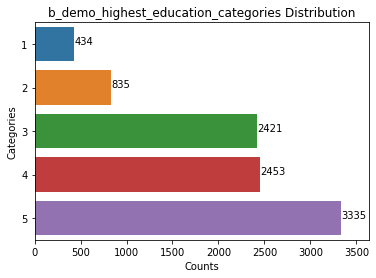

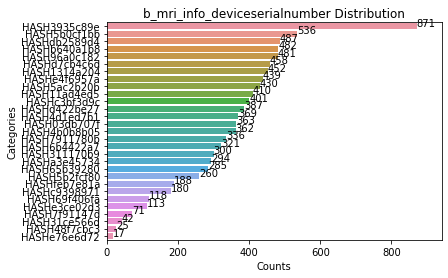

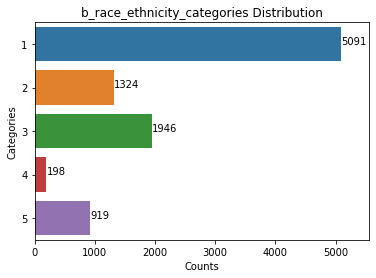

/home/sage/anaconda3/envs/bpt/lib/python3.9/site-packages/BPt/dataset/helpers.py:232: UserWarning: Skipping plot: b_rel_family_id as >= categories!
  warnings.warn(as_str)


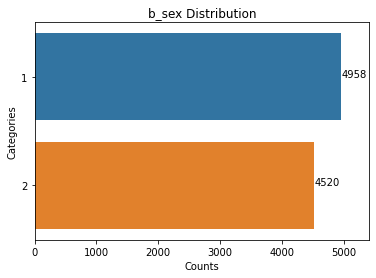

In [7]:
data = data.ordinalize([cat_covars, 'b_rel_family_id'])

# Then plot just the categorical variables
data.plot(scope='category', subjects='all', decode_values=True)

Let's plot the target variables as well.

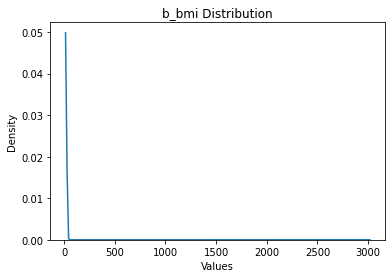

In [8]:
data.plot('target')

Okay, we note that there are some extreme outliers.

In [9]:
data = data.filter_outliers_by_std(n_std=10, scope='target')
data['target'].max()

Dropped 1 Rows


b_bmi   53.90845
dtype: float64

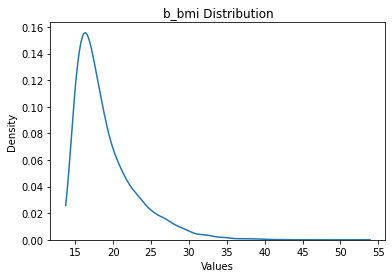

In [10]:
data.plot('target')

Okay this maximum seem much more reasonable. Let's also assume that there may be some extreme values present in the input data as well, and that these represet corrupted data that we therefore want to drop.

In [11]:
# Repeat it twice, to deal with outliers at multiple scales
data = data.filter_outliers_by_std(n_std=10, scope='float')
data = data.filter_outliers_by_std(n_std=10, scope='float')

Dropped 62 Rows
Dropped 14 Rows


Next, we consider splitting up out data with a global train and test split. This can be useful in some instances. Note that we also define a cv strategy which says to perform the train test split keeping members of the same family in the same fold.

In [12]:
# Let's say we want to keep family members in the same train or test split
cv_strategy = bp.CVStrategy(groups='b_rel_family_id')

# Test split
data = data.set_test_split(.2, random_state=5, cv_strategy=cv_strategy)
data

Performing test split on: 9401 subjects.
random_state: 5
Test split size: 0.2

Performed train/test split
Train size: 7481
Test size:  1920


,b_agemos,b_demo_highest_education_categories,b_mri_info_deviceserialnumber,b_race_ethnicity_categories,b_sex,dmri_dti_full_fa_subcort_aseg_accumbens_area_lh,dmri_dti_full_fa_subcort_aseg_accumbens_area_rh,dmri_dti_full_fa_subcort_aseg_amygdala_lh,dmri_dti_full_fa_subcort_aseg_amygdala_rh,dmri_dti_full_fa_subcort_aseg_caudate_lh,...,smri_vol_scs_subcorticalgv,smri_vol_scs_suprateialv,smri_vol_scs_tplh,smri_vol_scs_tprh,smri_vol_scs_vedclh,smri_vol_scs_vedcrh,smri_vol_scs_wholeb,smri_vol_scs_wmhint,smri_vol_scs_wmhintlh,smri_vol_scs_wmhintrh
0,124,1,26,1,0,0.17195,0.17389,0.19923,0.16654,0.15518,...,"52,440.00000","935,475.83514","6,220.90000","5,787.40000","3,554.80000","3,427.90000","1,045,923.63514",478.40000,0.00000,0.00000
1,122,4,2,0,1,0.16897,0.16477,0.20000,0.17713,0.15848,...,"62,550.00000","1,078,644.86257","8,222.60000","7,571.40000","3,872.50000","3,837.40000","1,197,394.06258",769.70000,0.00000,0.00000
2,114,2,13,0,0,0.22881,0.25250,0.23221,0.22298,0.22545,...,"60,695.00000","1,133,471.50460","7,040.50000","6,752.90000","4,588.80000","4,631.50000","1,291,126.70460","1,114.70000",0.00000,0.00000
3,130,4,2,0,1,0.16737,0.18840,0.15135,0.16215,0.18848,...,"65,614.00000","1,055,580.45187","8,365.70000","7,656.40000","4,600.10000","4,920.60000","1,189,841.05187","1,788.50000",0.00000,0.00000
4,115,4,20,0,1,0.18902,0.21375,0.23945,0.20581,0.20100,...,"59,174.00000","1,010,567.33270","6,577.90000","6,612.70000","3,434.30000","3,942.60000","1,144,069.73270","1,036.30000",0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9717,119,1,2,2,1,0.16392,0.17222,0.19906,0.17829,0.15375,...,"47,422.00000","893,537.35606","6,066.30000","5,342.00000","2,808.40000","3,469.60000","999,770.35606","1,152.40000",0.00000,0.00000
9720,129,4,7,0,1,0.23469,0.25338,0.25971,0.26321,0.22641,...,"59,348.00000","1,070,071.00812","7,036.60000","6,669.10000","3,817.40000","4,103.40000","1,198,435.10812",794.90000,0.00000,0.00000
9721,108,2,0,1,0,0.15469,0.20223,0.17145,0.15300,0.15900,...,"63,328.00000","1,093,051.50897","8,123.20000","7,346.20000","3,992.80000","4,219.80000","1,213,030.80897",805.50000,0.00000,0.00000
9722,110,2,17,0,1,0.16530,0.22484,0.19524,0.16084,0.16671,...,"57,037.00000","997,648.58273","6,692.50000","6,437.90000","3,833.40000","3,887.70000","1,127,133.48273","1,477.90000",0.00000,0.00000


## Single Training Set Evaluation

Our Dataset is now fully prepared. We can now define and evaluate a machine learning pipeline.
We will start by considering a pipeline which a few steps, these are:

1. Winsorize just the brain data.
2. Perform Robust Scaling on any 'float' type columns, 'brain' or 'covars'
3. One Hot Encode any categorical features
4. Fit an Elastic-Net Regression with nested random hyper-parameter search

Let's use one other feature of the toolbox, that is a custom cross-validation strategy. This is the same idea that we used when defining the train-test split, but now we want it to apply both during the evaluation and during the splits made when evaluating hyper-parameters.

In [13]:
#1
w_scaler = bp.Scaler('winsorize', quantile_range=(2, 98), scope='brain')

#2
s_scaler = bp.Scaler('standard', scope='float')

#3
ohe = bp.Transformer('one hot encoder', scope='category')

#4
param_search=bp.ParamSearch('RandomSearch', n_iter=60,
                            cv=bp.CV(splits=3, cv_strategy=cv_strategy))
elastic = bp.Model('elastic', params=1,
                   param_search=param_search)

# Now we can actually defined the pipeline
pipe = bp.Pipeline(steps=[w_scaler, s_scaler, ohe, elastic])
pipe

Pipeline(steps=[Scaler(extra_params={'quantile_range': (2, 98)},
                       obj='winsorize', scope='brain'),
                Scaler(obj='standard'),
                Transformer(obj='one hot encoder', scope='category'),
                Model(obj='elastic',
                      param_search=ParamSearch(cv=CV(cv_strategy=CVStrategy(groups='b_rel_family_id')),
                                               n_iter=60),
                      params=1)])

Let's say we want to use a 5-fold CV to evaluate this model on just the training set. We can first define the cv, the same as for the param_search above, but this time with splits=5. 

In [14]:
cv=bp.CV(splits=5, n_repeats=1, cv_strategy=cv_strategy)
cv

CV(cv_strategy=CVStrategy(groups='b_rel_family_id'), splits=5)

And we will make a problem_spec to store some common params. In this case the random state for reproducibility of results and the number of jobs to use.

In [15]:
# Use problem spec just to store n jobs and random state
ps = bp.ProblemSpec(n_jobs=8, random_state=10)
ps

ProblemSpec(n_jobs=8, random_state=10)

Now we are ready to evaluate this pipeline, let's check an example using the function evaluate.

We will set just one specific parameter to start, which is a scope of 'brain' to say
we just want to run a model with just the brain features (i.e., not the co-variates)


In [16]:
evaluator = bp.evaluate(pipeline=pipe,
                        dataset=data,
                        problem_spec=ps,
                        scope='brain',
                        mute_warnings=True,
                        cv=cv)
evaluator

Predicting target = b_bmi
Using problem_type = regression
Using scope = brain (defining a total of 661 features).
Evaluating 7481 total data points.


Folds:   0%|          | 0/5 [00:00<?, ?it/s]


Training Set: (6005, 661)
Validation Set: (1476, 661)
Fit fold in 20.4 seconds.
explained_variance: 0.2415
neg_mean_squared_error: -11.43

Training Set: (6007, 661)
Validation Set: (1474, 661)
Fit fold in 18.3 seconds.
explained_variance: 0.2808
neg_mean_squared_error: -13.52

Training Set: (5973, 661)
Validation Set: (1508, 661)
Fit fold in 18.5 seconds.
explained_variance: 0.2521
neg_mean_squared_error: -13.06

Training Set: (5988, 661)
Validation Set: (1493, 661)
Fit fold in 18.4 seconds.
explained_variance: 0.2958
neg_mean_squared_error: -10.48

Training Set: (5951, 661)
Validation Set: (1530, 661)
Fit fold in 18.2 seconds.
explained_variance: 0.2291
neg_mean_squared_error: -11.99



EvalResults
------------
explained_variance: 0.2599 ± 0.0248
neg_mean_squared_error: -12.10 ± 1.10

Saved Attributes: ['estimators', 'preds', 'timing', 'estimator', 'train_subjects', 'val_subjects', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_', 'cv']

Available Methods: ['to_pickle', 'compare', 'get_X_transform_df', 'get_inverse_fis', 'run_permutation_test', 'get_preds_dfs', 'subset_by', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated With:
target: b_bmi
problem_type: regression
scope: brain
subjects: train
random_state: 10
n_jobs: 8


Wait, what subset of subjects did we use? We want to make sure we are using just the training set of subjects at this stage. We just used default for the subjects, which in this case, i.e., when their is a test set defined, uses the training set as the subjects when passed to evaluate. We can confirm this by checking the intersection of the first train and validation fold with the test subjects

In [17]:
evaluator.train_subjects[0].intersection(data.test_subjects), evaluator.val_subjects[0].intersection(data.test_subjects)

(Int64Index([], dtype='int64'), Int64Index([], dtype='int64'))

As we can see, they are empty. We could also specify subjects='train' above to make sure this behavior occured.

## How to employ Test Set?

Next, we will discuss briefly two methods of evaluating on the test set.

1. There is a notion in some of the literature that the test set should be used to evaluate an existing estimator. In this case, that would consist of selecting from the 5 trained models we evaluated on the train set, and testing the one which performed best.

2. On the otherhand, we could instead re-train an estimator on the full training set and then test that on the test set. This is actually the reccomended strategy, but its still worth comparing both below.

Let's first do strategy 1.

In [18]:
# Get best model
best_model_ind = np.argmax(evaluator.scores['explained_variance'])
best_model = evaluator.estimators[best_model_ind]

# Get the correct test data - setting the problem spec
# as the problem spec saved when running this evaluator
X_test, y_test = data.get_Xy(problem_spec=evaluator.ps,
                             subjects='test')

# Score
score = best_model.score(X_test, y_test)
print(score)

0.281600708622071


Next, lets compare that with re-training our model on the full training set, then testing. 

In [19]:
evaluator = bp.evaluate(pipeline=pipe,
                        dataset=data,
                        problem_spec=ps,
                        scope='brain', # Same as before
                        mute_warnings=True,
                        cv='test')

evaluator

Predicting target = b_bmi
Using problem_type = regression
Using scope = brain (defining a total of 661 features).
Evaluating 9401 total data points.


Folds:   0%|          | 0/1 [00:00<?, ?it/s]


Training Set: (7481, 661)
Validation Set: (1920, 661)
Fit fold in 21.3 seconds.
explained_variance: 0.2855
neg_mean_squared_error: -12.10



EvalResults
------------
explained_variance: 0.2855 ± 0.0000
neg_mean_squared_error: -12.10 ± 0.0000

Saved Attributes: ['estimators', 'preds', 'timing', 'estimator', 'train_subjects', 'val_subjects', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_', 'cv']

Available Methods: ['to_pickle', 'compare', 'get_X_transform_df', 'get_inverse_fis', 'run_permutation_test', 'get_preds_dfs', 'subset_by', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated With:
target: b_bmi
problem_type: regression
scope: brain
subjects: all
random_state: 10
n_jobs: 8


Note that in this case, when cv='test' then all of the subjects will be used. If we wanted to make this behavior explicit we couldpass subjects='all'.

We can see that the results difer, though not hugely. One explanation is that at these sample sizes we still get boosts in performance from sample size, which means we expect our final model trained on the full and larger training set to do better. Another contributing factor is that by selecting from the 5-folds the model which does 'best' we may actually be choosing an overfit model which happened to do better on its corresponding validation set. We therefore reccomend the latter strategy.

In fact, we can formalize this intution, and test it on just the training set. We can do this because really the first method is just a type of meta-estimator. What it does is just in an internal nesting step, trains five models and selects the best one. We can formalize this as a custom model and compare it below.

We will also change the pipeline being compared a little bit for simplicity, replacing the elastic net we made via BPt with the ElasticNetCV object from scikit-learn.

In [20]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import ElasticNetCV
from sklearn.base import BaseEstimator

class BestOfModel(BaseEstimator):
    
    def __init__(self, estimator, cv=5):
        
        self.estimator = estimator
        self.cv = cv
        
    def fit(self, X, y):
        
        scores = cross_validate(self.estimator, X, y, cv=self.cv,
                                return_estimator=True)
        
        best_ind = np.argmax(scores['test_score'])
        self.estimator_ = scores['estimator'][best_ind]
        
    def predict(self, X):
        
        return self.estimator_.predict(X)


# The new elastic net cv to use
new_elastic = ElasticNetCV()

# The best of model
best_of_model = bp.Model(
    BestOfModel(estimator=new_elastic, cv=5))

# The static model
static_model = bp.Model(new_elastic)

# Use the same initial steps as before, but now with the best of model and the static models
best_of_pipe = bp.Pipeline(steps=[w_scaler, s_scaler, ohe, best_of_model])
static_pipe = bp.Pipeline(steps=[w_scaler, s_scaler, ohe, static_model])

Let's try the best of model first, evaluating it on the training set with 5-fold CV.

Note: This is going to be a bit slow as each time a model is trained in one of the 5-folds it needs to internally train 5 models. So it should take roughly 5x longer to evaluate then it's static counterpart.

In [21]:
evaluator = bp.evaluate(pipeline=best_of_pipe,
                        dataset=data,
                        problem_spec=ps, 
                        scope='brain',
                        mute_warnings=True,
                        cv=cv)

evaluator

Predicting target = b_bmi
Using problem_type = regression
Using scope = brain (defining a total of 661 features).
Evaluating 7481 total data points.


Folds:   0%|          | 0/5 [00:00<?, ?it/s]


Training Set: (6005, 661)
Validation Set: (1476, 661)
Fit fold in 207.9 seconds.
explained_variance: 0.2314
neg_mean_squared_error: -11.57

Training Set: (6007, 661)
Validation Set: (1474, 661)
Fit fold in 208.0 seconds.
explained_variance: 0.2667
neg_mean_squared_error: -13.80

Training Set: (5973, 661)
Validation Set: (1508, 661)
Fit fold in 211.4 seconds.
explained_variance: 0.2481
neg_mean_squared_error: -13.13

Training Set: (5988, 661)
Validation Set: (1493, 661)
Fit fold in 214.5 seconds.
explained_variance: 0.2833
neg_mean_squared_error: -10.65

Training Set: (5951, 661)
Validation Set: (1530, 661)
Fit fold in 291.8 seconds.
explained_variance: 0.2131
neg_mean_squared_error: -12.25



EvalResults
------------
explained_variance: 0.2485 ± 0.0249
neg_mean_squared_error: -12.28 ± 1.11

Saved Attributes: ['estimators', 'preds', 'timing', 'estimator', 'train_subjects', 'val_subjects', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'cv']

Available Methods: ['to_pickle', 'compare', 'get_X_transform_df', 'get_inverse_fis', 'run_permutation_test', 'get_preds_dfs', 'subset_by', 'permutation_importance']

Evaluated With:
target: b_bmi
problem_type: regression
scope: brain
subjects: train
random_state: 10
n_jobs: 8


Next, let's run its corresponding 'static' counterpart.

In [22]:
evaluator = bp.evaluate(pipeline=static_pipe,
                        dataset=data,
                        problem_spec=ps,
                        scope='brain',
                        mute_warnings=True,
                        cv=cv)

evaluator

Predicting target = b_bmi
Using problem_type = regression
Using scope = brain (defining a total of 661 features).
Evaluating 7481 total data points.


Folds:   0%|          | 0/5 [00:00<?, ?it/s]


Training Set: (6005, 661)
Validation Set: (1476, 661)
Fit fold in 17.9 seconds.
explained_variance: 0.2440
neg_mean_squared_error: -11.40

Training Set: (6007, 661)
Validation Set: (1474, 661)
Fit fold in 18.0 seconds.
explained_variance: 0.2803
neg_mean_squared_error: -13.53

Training Set: (5973, 661)
Validation Set: (1508, 661)
Fit fold in 19.5 seconds.
explained_variance: 0.2522
neg_mean_squared_error: -13.05

Training Set: (5988, 661)
Validation Set: (1493, 661)
Fit fold in 19.6 seconds.
explained_variance: 0.2913
neg_mean_squared_error: -10.54

Training Set: (5951, 661)
Validation Set: (1530, 661)
Fit fold in 18.6 seconds.
explained_variance: 0.2238
neg_mean_squared_error: -12.08



EvalResults
------------
explained_variance: 0.2583 ± 0.0245
neg_mean_squared_error: -12.12 ± 1.08

Saved Attributes: ['estimators', 'preds', 'timing', 'estimator', 'train_subjects', 'val_subjects', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_', 'cv']

Available Methods: ['to_pickle', 'compare', 'get_X_transform_df', 'get_inverse_fis', 'run_permutation_test', 'get_preds_dfs', 'subset_by', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated With:
target: b_bmi
problem_type: regression
scope: brain
subjects: train
random_state: 10
n_jobs: 8


These results confirm the intution, namely that it is better to re-train using as many subjects as possible rather than chose a 'best model' from an internal CV.

## Compare & Evaluate

Let's now try out a newer feature the input class Compare. Let's define as our options to compare using different subsets of the input data.

In [23]:
compare_scopes = bp.Compare(['covars', 'brain', 'all',
                             'thick', 'area', 'subcort',
                             'dti_fa', 'dti_md'])

evaluators = bp.evaluate(pipeline=pipe,
                         scope=compare_scopes,
                         dataset=data,
                         problem_spec=ps,
                         mute_warnings=True,
                         cv=cv)

# Look at a summary of the results - note this option is only available after a call to evaluate with
# Compare's has been made!
evaluators.summary()

Running Compare: Options(scope=covars)
Predicting target = b_bmi
Using problem_type = regression
Using scope = covars (defining a total of 5 features).
Evaluating 7481 total data points.


Compare:   0%|          | 0/8 [00:00<?, ?it/s]

Folds:   0%|          | 0/5 [00:00<?, ?it/s]


Training Set: (6005, 5)
Validation Set: (1476, 5)
Fit fold in 7.4 seconds.
explained_variance: 0.1243
neg_mean_squared_error: -13.19

Training Set: (6007, 5)
Validation Set: (1474, 5)
Fit fold in 5.8 seconds.
explained_variance: 0.1021
neg_mean_squared_error: -16.88

Training Set: (5973, 5)
Validation Set: (1508, 5)
Fit fold in 6.1 seconds.
explained_variance: 0.1190
neg_mean_squared_error: -15.38

Training Set: (5988, 5)
Validation Set: (1493, 5)
Fit fold in 6.1 seconds.
explained_variance: 0.1240
neg_mean_squared_error: -13.07

Training Set: (5951, 5)
Validation Set: (1530, 5)
Fit fold in 6.0 seconds.
explained_variance: 0.0973
neg_mean_squared_error: -14.06

Running Compare: Options(scope=brain)
Predicting target = b_bmi
Using problem_type = regression
Using scope = brain (defining a total of 661 features).
Evaluating 7481 total data points.

Training Set: (6005, 661)
Validation Set: (1476, 661)
Fit fold in 18.7 seconds.
explained_variance: 0.2415
neg_mean_squared_error: -11.43

Tr

,mean_scores_explained_variance,mean_scores_neg_mean_squared_error,std_scores_explained_variance,std_scores_neg_mean_squared_error
scope,,,,
covars,0.11336,-14.51440,0.01140,1.44398
brain,0.25987,-12.09649,0.02480,1.09710
all,0.28081,-11.75993,0.02336,1.11410
thick,0.10112,-14.69537,0.02830,1.38550
area,0.02627,-15.92036,0.00515,1.46166
subcort,0.05195,-15.50432,0.00841,1.38632
dti_fa,0.10258,-14.67512,0.00686,1.38980
dti_md,0.14444,-13.98214,0.00955,1.25276


We can also try another method available which will run a pairwise model ttest comparison between all options

In [24]:
evaluators.pairwise_t_stats(metric='explained_variance')

,scope (1),scope (2),t_stat,p_val
0,covars,brain,-10.82970,0.00577
1,covars,all,-13.83988,0.00221
2,covars,thick,0.83951,1.00000
3,covars,area,9.90478,0.00816
4,covars,subcort,9.15809,0.01105
5,covars,dti_fa,2.14552,1.00000
6,covars,dti_md,-5.31640,0.08428
7,brain,all,-10.37148,0.00683
8,brain,thick,31.64242,0.00008
9,brain,area,17.62922,0.00085


We can also explicitly compare two evaluators

In [25]:
e1 = evaluators['scope=covars']
e2 = evaluators['scope=brain']

# Look at function docstring
print('       ', e1.compare.__doc__)
print()

e1.compare(e2)

        This method is designed to perform a statistical comparison
        between the results from the evaluation stored in this object
        and another instance of :class:`EvalResults`. The statistics
        produced here are explained in:
        https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html

        .. note::
            In the case that the sizes of the training and validation sets
            at each fold vary dramatically, it is unclear if this
            statistics are still valid.
            In that case, the mean train size and mean validation sizes
            are employed when computing statistics.

        Parameters
        ------------
        other : :class:`EvalResults`
            Another instance of :class:`EvalResults` in which
            to compare which. The cross-validation used
            should be the same in both instances, otherwise
            statistics will not be generated.

        rope_interval : list

,mean_diff,std_diff,t_stat,p_val,better_prob,worse_prob,rope_prob
explained_variance,-0.14651,-0.01340,-10.82970,0.00021,0.00016,0.99973,0.00011
neg_mean_squared_error,-2.41791,0.34688,-7.88308,0.00070,0.00069,0.99929,0.00002


Okay so it looks like it ran all the different combinations, but how do we look at each indivudal evaluator / the full results?? There are few different ways to index the object storing the different evaluators, but its essentially a dictionary. We can index one run as follows:

In [26]:
evaluators['scope=covars']

EvalResults
------------
explained_variance: 0.1134 ± 0.0114
neg_mean_squared_error: -14.51 ± 1.44

Saved Attributes: ['estimators', 'preds', 'timing', 'estimator', 'train_subjects', 'val_subjects', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_', 'cv']

Available Methods: ['to_pickle', 'compare', 'get_X_transform_df', 'get_inverse_fis', 'run_permutation_test', 'get_preds_dfs', 'subset_by', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated With:
target: b_bmi
problem_type: regression
scope: covars
subjects: train
random_state: 10
n_jobs: 8


In [27]:
# Note, with get_fis, if mean=True it will return
# the mean and only non-null, and non-zero features directly.
evaluators['scope=covars'].get_fis(mean=True)

b_demo_highest_education_categories=1           0.64939
b_demo_highest_education_categories=2           0.67197
b_demo_highest_education_categories=3           0.04776
b_demo_highest_education_categories=4          -0.74633
b_demo_highest_education_categories=5          -1.07322
b_mri_info_deviceserialnumber='HASH03db707f'    0.21938
b_mri_info_deviceserialnumber='HASH11ad4ed5'   -0.63669
b_mri_info_deviceserialnumber='HASH1314a204'   -0.73412
b_mri_info_deviceserialnumber='HASH311170b9'   -0.21010
b_mri_info_deviceserialnumber='HASH31ce566d'   -0.00672
b_mri_info_deviceserialnumber='HASH3935c89e'   -0.44180
b_mri_info_deviceserialnumber='HASH4b0b8b05'    0.06497
b_mri_info_deviceserialnumber='HASH4d1ed7b1'    0.00365
b_mri_info_deviceserialnumber='HASH5ac2b20b'   -0.02957
b_mri_info_deviceserialnumber='HASH5b0cf1bb'    0.05611
b_mri_info_deviceserialnumber='HASH5b2fcf80'   -0.37144
b_mri_info_deviceserialnumber='HASH65b39280'    0.50217
b_mri_info_deviceserialnumber='HASH69f406fa'    

Warning: This doesn't mean that this mean features were selected! Remember this is the average over training 5 models, so it means that if a feature shows up it was selected at least once in one of the models!

In [28]:
# These are the different options
evaluators.keys()

dict_keys([Options(scope=covars), Options(scope=brain), Options(scope=all), Options(scope=thick), Options(scope=area), Options(scope=subcort), Options(scope=dti_fa), Options(scope=dti_md)])